# **Line Keep Assist (LKA) — Classical Computer Vision Pipeline**

##*Name: Jamin Rahman Jim*

##*ELTE Student ID: A11344*

This notebook presents a **complete Line Keep Assist (LKA)** implementation using a **Classical Computer Vision (CV)** approach.  
It follows the lab specifications for the ADAS (Advanced Driver Assistance Systems) perception stack and demonstrates how lane detection, geometry estimation, and control inputs can be derived from road video.

---

## Overview

The system processes a driving video frame by frame to detect and track lane boundaries.  
It estimates key metrics such as lane curvature, lateral offset, and confidence values — forming the foundation of a perception-based **Line Keep Assist** system.

### Key Features:
- **Lane boundary detection** using **HLS color** and **Sobel gradient** thresholds  
- **Bird's-eye transformation** (perspective warp) for geometric consistency  
- **Histogram-based sliding window** search for lane pixel extraction  
- **2nd-order polynomial fits** for smooth lane curve modeling  
- **Lightweight temporal smoothing** of polynomial coefficients and confidence values  
- **Confidence estimation** and **lateral offset** (in both pixels and meters)  
- **Real-time annotated overlay** (HUD) for visualization and performance evaluation  


---

## Pipeline Summary

| Step | Description |
|------|--------------|
| **1. Preprocessing** | Apply HLS and Sobel-x thresholds to emphasize lane markings. |
| **2. Perspective Transform** | Warp the road region to a top-down (bird's-eye) view. |
| **3. Lane Detection** | Use histogram peaks to initialize sliding window search. |
| **4. Polynomial Fit** | Fit 2nd-order curves to left and right lane points. |
| **5. Temporal Smoothing** | Exponentially smooth polynomial coefficients and confidence values across frames. |
| **6. Metrics & Alerts** | Compute curvature, scale, lateral offset, and “driver takeover” warnings if confidence is low. |
| **7. Visualization & Output** | Generate an annotated video and a CSV log with frame-wise telemetry data. |



---

## Outputs

After running the full notebook, you will obtain:

| File | Description |
|------|--------------|
| **`annotated_video.mp4`** | Final video with lane overlays, curvature, offset, and confidence displayed as a HUD. |
| 📄 **`per_frame_polyfit.csv`** | CSV log containing per-frame metrics (left/right detection, confidence, offset, etc.). |

---

## Usage Instructions

1. **Upload your driving video** (e.g., `video_1.mp4`) to your Colab workspace.  
2. **Update the `VIDEO_PATH` variable** in the setup cell below to match your file name.  
3. **Run all notebook cells in order** from top to bottom.  
4. Once complete, you can **preview or download** both the annotated video and CSV output.

---



In [123]:
import cv2, numpy as np, pandas as pd
from base64 import b64encode
from IPython.display import HTML, display
print('Imports ready')


Imports ready


In [124]:
# -----------------------------
# Parameters — edit VIDEO_PATH after upload
# -----------------------------
VIDEO_PATH = "/content/video_1.mp4"
OUTPUT_VIDEO = "annotated_video.mp4"
OUTPUT_CSV = "per_frame_polyfit.csv"

# Tuned perspective warp — more stable top width and distance
SRC_RATIOS = np.float32([
    [0.10, 0.94],   # bottom-left
    [0.40, 0.60],   # top-left (a bit lower and wider)
    [0.60, 0.60],   # top-right
    [0.90, 0.94]    # bottom-right
])



# Bird’s-eye rectangle (keep same)
DST_RATIOS = np.float32([
    [0.20, 1.00],
    [0.20, 0.00],
    [0.80, 0.00],
    [0.80, 1.00]
])

# Thresholds (robust for mixed contrast)
S_THRESH = (90, 255)
SX_THRESH = (15, 120)

# Sliding window parameters
N_WINDOWS = 9
MARGIN = 110    # slightly wider — prevents narrow top oscillation
MINPIX = 40     # keeps lanes connected even with fewer pixels

# Temporal smoothing (stronger)
SMOOTH_ALPHA = 0.9   # higher = smoother curvature across frames
KEEP_FRAMES = 12     # retain previous fit longer on weak detections

# Real-world lane width
ASSUMED_LANE_M = 3.7

print(" Parameters set for robust, stable lane overlay.")


 Parameters set for robust, stable lane overlay.


In [125]:
# -----------------------------
# Helper functions: thresholding
# -----------------------------
def threshold_hls_sobel(img_bgr, s_thresh=S_THRESH, sx_thresh=SX_THRESH):
    """Return a binary mask combining S-channel and Sobel-x thresholds."""
    hls = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HLS)
    l = hls[:,:,1]
    s = hls[:,:,2]

    # Sobel x on L
    sobelx = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sx = np.uint8(255 * abs_sobelx / (np.max(abs_sobelx) + 1e-6))
    sx_binary = np.zeros_like(scaled_sx)
    sx_binary[(scaled_sx >= sx_thresh[0]) & (scaled_sx <= sx_thresh[1])] = 255

    # S channel for paint
    s_binary = np.zeros_like(s)
    s_binary[(s >= s_thresh[0]) & (s <= s_thresh[1])] = 255

    combined = cv2.bitwise_or(sx_binary, s_binary)
    return combined

def region_of_interest(binary, vertices):
    mask = np.zeros_like(binary)
    cv2.fillPoly(mask, [vertices], 255)
    return cv2.bitwise_and(binary, mask)

def get_perspective_transform(h, w, src_ratios, dst_ratios):
    src = (src_ratios * [w, h]).astype(np.float32)
    dst = (dst_ratios * [w, h]).astype(np.float32)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv, src, dst

def warp_binary(binary, M, w, h):
    return cv2.warpPerspective(binary, M, (w, h), flags=cv2.INTER_NEAREST)


In [126]:
# -----------------------------
# Sliding windows + polynomial fit
# -----------------------------
def sliding_window_polyfit(binary_warped, nwindows=N_WINDOWS, margin=MARGIN, minpix=MINPIX):
    h, w = binary_warped.shape
    histogram = np.sum(binary_warped[h//2:,:], axis=0)
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = h // nwindows
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = h - (window+1) * window_height
        win_y_high = h - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds) if len(left_lane_inds) else np.array([])
    right_lane_inds = np.concatenate(right_lane_inds) if len(right_lane_inds) else np.array([])

    leftx = nonzerox[left_lane_inds] if left_lane_inds.size else np.array([])
    lefty = nonzeroy[left_lane_inds] if left_lane_inds.size else np.array([])
    rightx = nonzerox[right_lane_inds] if right_lane_inds.size else np.array([])
    righty = nonzeroy[right_lane_inds] if right_lane_inds.size else np.array([])

    left_fit = np.polyfit(lefty, leftx, 2) if leftx.size and lefty.size else None
    right_fit = np.polyfit(righty, rightx, 2) if rightx.size and righty.size else None

    return left_fit, right_fit, (leftx, lefty, rightx, righty), histogram

def poly_to_points(fit, yvals):
    if fit is None:
        return None
    x = fit[0]*yvals**2 + fit[1]*yvals + fit[2]
    return np.stack([x, yvals], axis=1).astype(np.int32)


In [127]:
# -----------------------------
# Drawing, confidence, offset (Enhanced)
# -----------------------------
import cv2
import numpy as np

def draw_lane_overlay(original_bgr, binary_warped, left_fit, right_fit, Minv,
                      lconf=1.0, rconf=1.0, conf_thresh=0.6):
    """
    Draws lane overlay with confidence-based coloring.
    High confidence = solid lines (green/blue)
    Low confidence   = dashed gray lines
    """
    h, w = binary_warped.shape
    yvals = np.linspace(0, h-1, h)
    left_pts = poly_to_points(left_fit, yvals)
    right_pts = poly_to_points(right_fit, yvals)

    lane_area = np.zeros((h, w, 3), dtype=np.uint8)

    # --- Fill ego-lane only if both lanes are valid ---
    if left_pts is not None and right_pts is not None:
        pts = np.vstack((left_pts, right_pts[::-1]))
        cv2.fillPoly(lane_area, [pts], (0, 255, 0))  # green fill for ego-lane

    # --- Dynamic color by confidence ---
    def conf_color(conf, base_color):
        if conf > 0.8:
            return base_color  # normal (green/blue)
        elif conf > conf_thresh:
            return (0, 255, 255)  # yellow mid confidence
        else:
            return (160, 160, 160)  # gray low confidence

    # --- Draw polylines ---
    if left_pts is not None:
        cv2.polylines(lane_area, [left_pts], isClosed=False,
                      color=conf_color(lconf, (0, 255, 0)), thickness=12)
    if right_pts is not None:
        cv2.polylines(lane_area, [right_pts], isClosed=False,
                      color=conf_color(rconf, (255, 0, 0)), thickness=12)

    # Warp back to original perspective
    newwarp = cv2.warpPerspective(lane_area, Minv, (original_bgr.shape[1], original_bgr.shape[0]))
    overlay = cv2.addWeighted(original_bgr, 0.85, newwarp, 0.6, 0)
    return overlay


def fit_confidence(left_data, right_data, left_fit, right_fit, h, w=None,
                   prev_left_fit=None, prev_right_fit=None):
    """
    Compute lane confidence with added geometric sanity checks:
      - pixel count & residuals
      - vertical span
      - curvature similarity
      - lane width validity
      - temporal stability (vs. previous frame)
    """
    leftx, lefty, rightx, righty = left_data[0], left_data[1], right_data[2], right_data[3]

    # --- Internal scoring (base heuristic) ---
    def score(x, y, fit):
        if fit is None or x.size == 0:
            return 0.0
        x_pred = fit[0]*y**2 + fit[1]*y + fit[2]
        resid = np.mean(np.abs(x - x_pred)) if x.size else 1e6
        count_term = np.tanh(x.size / 800)
        resid_term = np.exp(-resid / 40)
        vertical_span = (y.max() - y.min()) / h if y.size else 0
        return float(np.clip(0.5*count_term + 0.3*resid_term + 0.2*vertical_span, 0, 1))

    lconf = score(leftx, lefty, left_fit)
    rconf = score(rightx, righty, right_fit)

    # --- Lane width sanity check ---
    if left_fit is not None and right_fit is not None and w is not None:
        y_eval = h - 1
        xl = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        xr = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_width_px = abs(xr - xl)
        if lane_width_px < 0.3*w or lane_width_px > 0.8*w:
            lconf *= 0.2
            rconf *= 0.2

    # --- Curvature similarity check ---
    def curvature_from_fit(fit, y_eval, ym_per_pix=30/720, xm_per_pix=3.7/700):
        if fit is None:
            return None
        A, B, _ = fit
        return ((1 + (2*A*y_eval*ym_per_pix + B)**2)**1.5) / np.abs(2*A)
    if left_fit is not None and right_fit is not None:
        y_eval = h
        curv_l = curvature_from_fit(left_fit, y_eval)
        curv_r = curvature_from_fit(right_fit, y_eval)
        if curv_l is not None and curv_r is not None:
            ratio = curv_l / (curv_r + 1e-6)
            if ratio < 0.5 or ratio > 2.0:
                lconf *= 0.5
                rconf *= 0.5

    # --- Temporal consistency (vs. previous frame) ---
    if prev_left_fit is not None and left_fit is not None:
        delta_left = np.abs(left_fit[2] - prev_left_fit[2])
        if delta_left > 100:
            lconf *= 0.4
    if prev_right_fit is not None and right_fit is not None:
        delta_right = np.abs(right_fit[2] - prev_right_fit[2])
        if delta_right > 100:
            rconf *= 0.4

    return float(np.clip(lconf, 0, 1)), float(np.clip(rconf, 0, 1))


def lateral_offset_from_fits(left_fit, right_fit, w, h, lane_m=ASSUMED_LANE_M):
    """Compute pixel and meter offset of vehicle center from lane center."""
    if left_fit is None or right_fit is None:
        return 0.0, 0.0
    y = h - 1
    xl = left_fit[0]*y*y + left_fit[1]*y + left_fit[2]
    xr = right_fit[0]*y*y + right_fit[1]*y + right_fit[2]
    lane_center = 0.5*(xl + xr)
    img_center = w/2.0
    offset_px = img_center - lane_center
    px_lane_width = abs(xr - xl)
    if px_lane_width < 10:
        return float(offset_px), 0.0
    meters_per_px = lane_m / px_lane_width
    return float(offset_px), float(offset_px * meters_per_px)


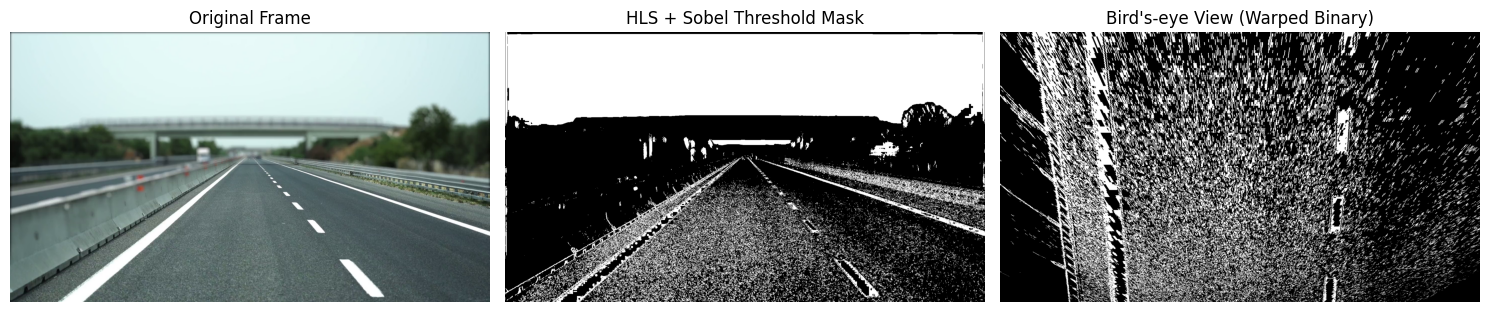

In [128]:
# -----------------------------
# Intermediate Stage Visualization (single-frame demo)
# -----------------------------
import matplotlib.pyplot as plt

# Open one frame from the input video
cap = cv2.VideoCapture(VIDEO_PATH)
ok, frame = cap.read()
cap.release()

if not ok:
    raise RuntimeError("Could not read the first frame from the video.")

# Apply each stage
binary = threshold_hls_sobel(frame)
M, Minv, src_pts, dst_pts = get_perspective_transform(frame.shape[0], frame.shape[1],
                                                      SRC_RATIOS, DST_RATIOS)
bird = warp_binary(binary, M, frame.shape[1], frame.shape[0])

# Visualize: Original → Threshold Mask → Bird’s-eye Warp
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Original Frame"); plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(binary, cmap='gray')
plt.title("HLS + Sobel Threshold Mask"); plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(bird, cmap='gray')
plt.title("Bird's-eye View (Warped Binary)"); plt.axis('off')

plt.tight_layout()
plt.show()


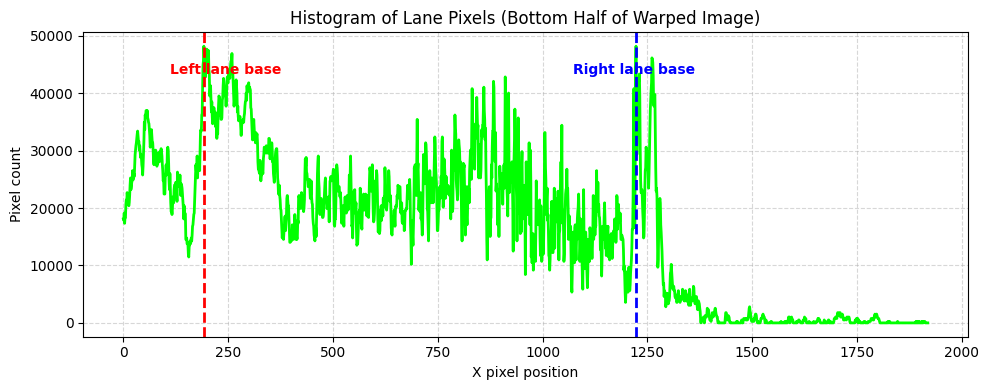

In [138]:
# -----------------------------
# Histogram Visualization
# -----------------------------
import matplotlib.pyplot as plt

# Read a mid-frame for visualization
cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, 200)  # choose a clear mid-frame
ok, frame = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read frame from video.")

# Preprocess: threshold + perspective transform
binary = threshold_hls_sobel(frame)
M, Minv, src_pts, dst_pts = get_perspective_transform(
    frame.shape[0], frame.shape[1], SRC_RATIOS, DST_RATIOS)
bird = warp_binary(binary, M, frame.shape[1], frame.shape[0])

# Compute histogram
hist = np.sum(bird[bird.shape[0]//2:, :], axis=0)

# Detect left and right lane base positions
left_peak = np.argmax(hist[:bird.shape[1]//2])
right_peak = np.argmax(hist[bird.shape[1]//2:]) + bird.shape[1]//2

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.plot(hist, color='lime', linewidth=2)
plt.title("Histogram of Lane Pixels (Bottom Half of Warped Image)")
plt.xlabel("X pixel position")
plt.ylabel("Pixel count")
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate lane bases
plt.axvline(left_peak, color='red', linestyle='--', linewidth=2)
plt.axvline(right_peak, color='blue', linestyle='--', linewidth=2)
plt.text(left_peak - 80, max(hist) * 0.9, 'Left lane base', color='red', fontsize=10, fontweight='bold')
plt.text(right_peak - 150, max(hist) * 0.9, 'Right lane base', color='blue', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [130]:
# -----------------------------
# Main Processing Loop (Robust Version with Polyfit Smoothing)
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 25

M, Minv, src_pts, dst_pts = get_perspective_transform(h, w, SRC_RATIOS, DST_RATIOS)

out = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

rows = []
frame_id = 0

# Previous fits and counters
prev_left_fit, prev_right_fit = None, None
keep_left, keep_right = 0, 0
lconf_hist, rconf_hist = 0.0, 0.0

def smooth_poly(current, previous, keep):
    """Exponential moving average + persistence."""
    if current is not None and previous is not None:
        current = SMOOTH_ALPHA * previous + (1 - SMOOTH_ALPHA) * current
        keep = KEEP_FRAMES
    elif current is None and previous is not None and keep > 0:
        current = previous
        keep -= 1
    elif current is not None:
        keep = KEEP_FRAMES
    return current, keep

while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Threshold (color + gradient)
    binary = threshold_hls_sobel(frame)

    # Warp to bird’s-eye
    bird = warp_binary(binary, M, w, h)

    # Sliding windows + polynomial fit
    left_fit, right_fit, data, hist = sliding_window_polyfit(bird)



    # Smooth polynomial coefficients across frames
    left_fit, keep_left = smooth_poly(left_fit, prev_left_fit, keep_left)
    right_fit, keep_right = smooth_poly(right_fit, prev_right_fit, keep_right)
    prev_left_fit, prev_right_fit = left_fit, right_fit

    # Confidence estimation
    # lconf, rconf = fit_confidence((data[0], data[1], data[2], data[3]),
    #                               (data[0], data[1], data[2], data[3]),
    #                               left_fit, right_fit, h)

    lconf, rconf = fit_confidence((data[0], data[1], data[2], data[3]),
                              (data[0], data[1], data[2], data[3]),
                              left_fit, right_fit, h, w,
                              prev_left_fit, prev_right_fit)

    lconf_hist = min(1.0, 0.85 * lconf_hist + 0.3 * lconf)
    rconf_hist = min(1.0, 0.85 * rconf_hist + 0.3 * rconf)

    # Overlay lanes back onto camera view
    overlay = draw_lane_overlay(frame, bird, left_fit, right_fit, Minv)

    # Lateral offset
    off_px, off_m = lateral_offset_from_fits(left_fit, right_fit, w, h)

    # HUD Text
    # left_detected = int(left_fit is not None)
    # right_detected = int(right_fit is not None)
    # cv2.putText(overlay, f"Left: {'YES' if left_detected else 'NO'} | Right: {'YES' if right_detected else 'NO'}",
    #             (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    # cv2.putText(overlay, f"Conf: L={lconf_hist:.2f}, R={rconf_hist:.2f}",
    #             (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 220, 220), 2)
    # cv2.putText(overlay, f"Lat offset: {off_m:.2f} m ({off_px:.0f} px)",
    #             (40, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 220, 220), 2)

    # HUD and Extended Metrics
    TAU = 0.6
    left_detected = int(lconf_hist > TAU)
    right_detected = int(rconf_hist > TAU)

    # --- Curvature calculation ---
    def curvature_from_fit(fit, y_eval, ym_per_pix=30/720, xm_per_pix=3.7/700):
        """Estimate radius of curvature (meters) from 2nd order polyfit."""
        if fit is None:
            return None
        A, B, _ = fit
        return ((1 + (2*A*y_eval*ym_per_pix + B)**2)**1.5) / np.abs(2*A)

    y_eval = h
    curv_l = curvature_from_fit(left_fit, y_eval)
    curv_r = curvature_from_fit(right_fit, y_eval)
    curvature_vals = [c for c in [curv_l, curv_r] if c is not None]
    curvature = np.mean(curvature_vals) if curvature_vals else 0.0

    # --- Speed advisory (km/h) ---
    safe_speed = min(120, 0.4 * np.sqrt(curvature)) if curvature > 0 else 0.0

    # --- Driver takeover alert ---
    if 'takeover_counter' not in locals():
        takeover_counter = 0
    if lconf_hist < TAU or rconf_hist < TAU:
        takeover_counter += 1
    else:
        takeover_counter = 0

    # --- HUD text drawing ---
    cv2.putText(overlay, f"Left: {'YES' if left_detected else 'NO'} | Right: {'YES' if right_detected else 'NO'}",
                (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(overlay, f"Conf: L={lconf_hist:.2f}, R={rconf_hist:.2f}",
                (40, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 220, 220), 2)
    cv2.putText(overlay, f"Lat offset: {off_m:.2f} m ({off_px:.0f} px)",
                (40, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (220, 220, 220), 2)
    cv2.putText(overlay, f"Curvature: {curvature:6.1f} m | Safe speed ≈ {safe_speed:.0f} km/h",
                (40, 160), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (200, 255, 200), 2)

    # --- Takeover warning ---
    if takeover_counter > 15:  # ~0.6 s at 25 FPS
        cv2.putText(overlay, "⚠ DRIVER TAKEOVER!", (40, 210),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

    # --- Optional scale info ---
    if right_fit is not None and left_fit is not None:
        y_bottom = h - 1
        xl = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]
        xr = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2]
        meters_per_px = 3.7 / abs(xr - xl)
        cv2.putText(overlay, f"Scale: {meters_per_px*100:.2f} cm/px",
                    (40, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (180, 255, 255), 2)


    # 9) Write output frame and save data
    out.write(overlay)
    rows.append([frame_id, left_detected, right_detected, lconf_hist, rconf_hist, off_m])
    frame_id += 1

cap.release()
out.release()
print(" Processing finished. Video and CSV will be saved.")


 Processing finished. Video and CSV will be saved.


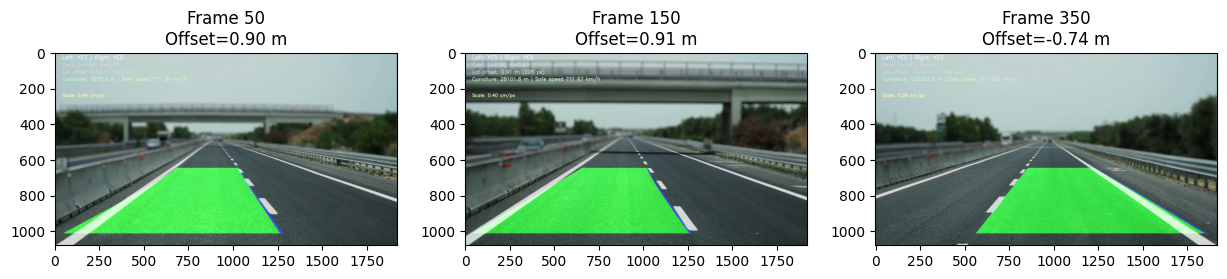

In [137]:
# -----------------------------
# Visualization of Final Annotated Frames
# -----------------------------
import matplotlib.pyplot as plt

video_path = OUTPUT_VIDEO
frame_ids = [50, 150, 350]  # choose any frames to show

cap = cv2.VideoCapture(video_path)
frames = {}
for fid in frame_ids:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ok, frame = cap.read()
    if ok:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames[fid] = frame_rgb
    else:
        print(f"Could not read frame {fid}")
cap.release()

# Optional: read metrics for captions
import pandas as pd
df = pd.read_csv(OUTPUT_CSV)

# Display frames in a grid with confidence/offset info
cols = len(frames)
plt.figure(figsize=(5*cols, 6))
for i, (fid, img) in enumerate(frames.items()):
    match = df.loc[df['frame_id'] == fid]
    if match.empty:
        print(f" Frame {fid} not found in CSV — skipping.")
        continue
    row = match.iloc[0]
    plt.subplot(1, cols, i+1)
    plt.imshow(img)
    plt.title(f"Frame {fid}\nOffset={row['lat_offset_m']:.2f} m")



In [132]:
# Save CSV + download links
df = pd.DataFrame(rows, columns=['frame_id','left_detected','right_detected','left_conf','right_conf','lat_offset_m'])
df.to_csv(OUTPUT_CSV, index=False)
print('CSV saved with', len(df), 'rows')

def download_link(filename):
    with open(filename, 'rb') as f:
        data = f.read()
    mime = 'video/mp4' if filename.endswith('.mp4') else 'text/csv'
    b64 = b64encode(data).decode()
    return HTML(f'<a download="{filename}" href="data:{mime};base64,{b64}">Download {filename}</a>')

#display(download_link(OUTPUT_VIDEO))
display(download_link(OUTPUT_CSV))
print('Due to file size limitation commented the output video link option!')


CSV saved with 429 rows


Due to file size limitation commented the output video link option!


In [133]:
# -----------------------------
# Evaluation Metrics
# -----------------------------
import numpy as np
import pandas as pd

df = pd.read_csv(OUTPUT_CSV)

# Threshold for detection confidence
TAU = 0.6

# Detection flags based on confidence
df['left_valid'] = df['left_conf'] > TAU
df['right_valid'] = df['right_conf'] > TAU

# Detection Accuracy
left_acc = df['left_valid'].mean()
right_acc = df['right_valid'].mean()

# Mean Confidence
mean_lconf = df['left_conf'].mean()
mean_rconf = df['right_conf'].mean()

# Mean Lateral Offset & Stability
mean_offset = df['lat_offset_m'].mean()
std_offset = df['lat_offset_m'].std()

# Temporal stability (frame-to-frame offset variation)
offset_diff = np.diff(df['lat_offset_m'])
temporal_stability = np.std(offset_diff)

# Flicker rate (frames where detection toggles on/off)
def flicker_rate(series):
    toggles = np.sum(np.abs(np.diff(series.astype(int))))
    return toggles / len(series)

left_flicker = flicker_rate(df['left_valid'])
right_flicker = flicker_rate(df['right_valid'])

# Print results neatly
print("=== LKA Evaluation Metrics ===")
print(f"Left Detection Accuracy:  {left_acc*100:.2f}%")
print(f"Right Detection Accuracy: {right_acc*100:.2f}%")
print(f"Mean Left Confidence:     {mean_lconf:.3f}")
print(f"Mean Right Confidence:    {mean_rconf:.3f}")
print(f"Mean Lateral Offset:      {mean_offset:.3f} m")
print(f"Offset Std (Stability):   {std_offset:.3f} m")
print(f"Temporal Stability:       {temporal_stability:.4f} m/frame")
print(f"Left Flicker Rate:        {left_flicker:.3f}")
print(f"Right Flicker Rate:       {right_flicker:.3f}")


=== LKA Evaluation Metrics ===
Left Detection Accuracy:  97.44%
Right Detection Accuracy: 96.74%
Mean Left Confidence:     0.911
Mean Right Confidence:    0.913
Mean Lateral Offset:      0.565 m
Offset Std (Stability):   0.671 m
Temporal Stability:       0.0391 m/frame
Left Flicker Rate:        0.002
Right Flicker Rate:       0.002


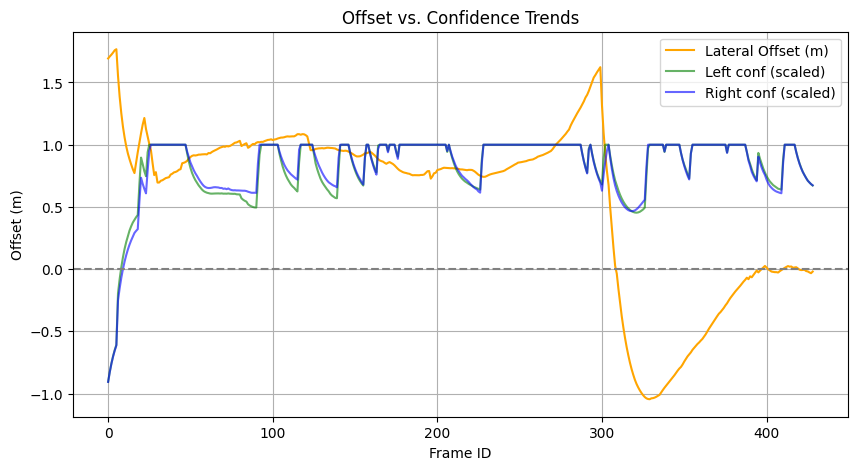

In [134]:
plt.figure(figsize=(10,5))
plt.plot(df['frame_id'], df['lat_offset_m'], label='Lateral Offset (m)', color='orange')
plt.plot(df['frame_id'], df['left_conf']*2 - 1, label='Left conf (scaled)', color='green', alpha=0.6)
plt.plot(df['frame_id'], df['right_conf']*2 - 1, label='Right conf (scaled)', color='blue', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Offset vs. Confidence Trends')
plt.xlabel('Frame ID'); plt.ylabel('Offset (m)')
plt.legend(); plt.grid(True)
plt.show()


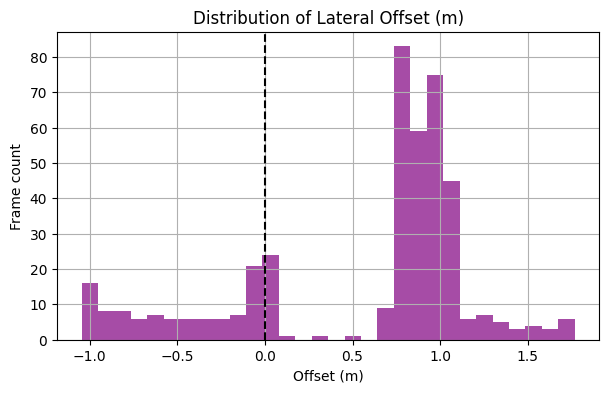

In [135]:
plt.figure(figsize=(7,4))
plt.hist(df['lat_offset_m'], bins=30, color='purple', alpha=0.7)
plt.axvline(0, color='black', linestyle='--')
plt.title('Distribution of Lateral Offset (m)')
plt.xlabel('Offset (m)'); plt.ylabel('Frame count')
plt.grid(True)
plt.show()


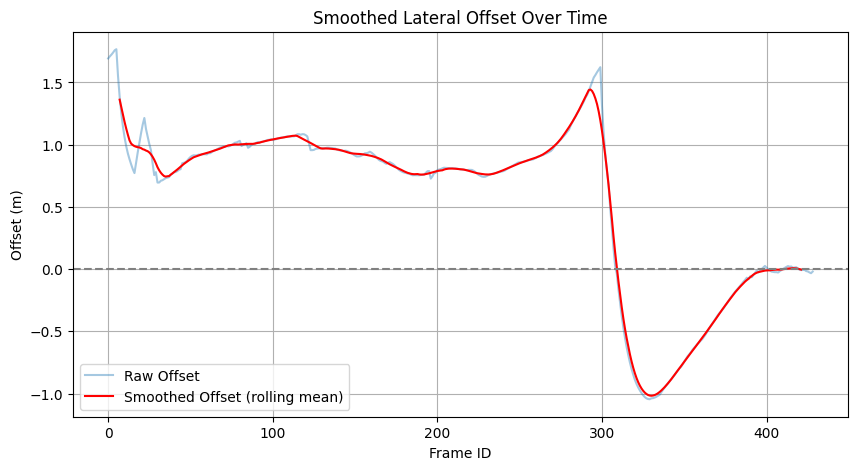

In [136]:
df['offset_smooth'] = df['lat_offset_m'].rolling(window=15, center=True).mean()

plt.figure(figsize=(10,5))
plt.plot(df['frame_id'], df['lat_offset_m'], label='Raw Offset', alpha=0.4)
plt.plot(df['frame_id'], df['offset_smooth'], label='Smoothed Offset (rolling mean)', color='red')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Smoothed Lateral Offset Over Time')
plt.xlabel('Frame ID'); plt.ylabel('Offset (m)')
plt.legend(); plt.grid(True)
plt.show()
